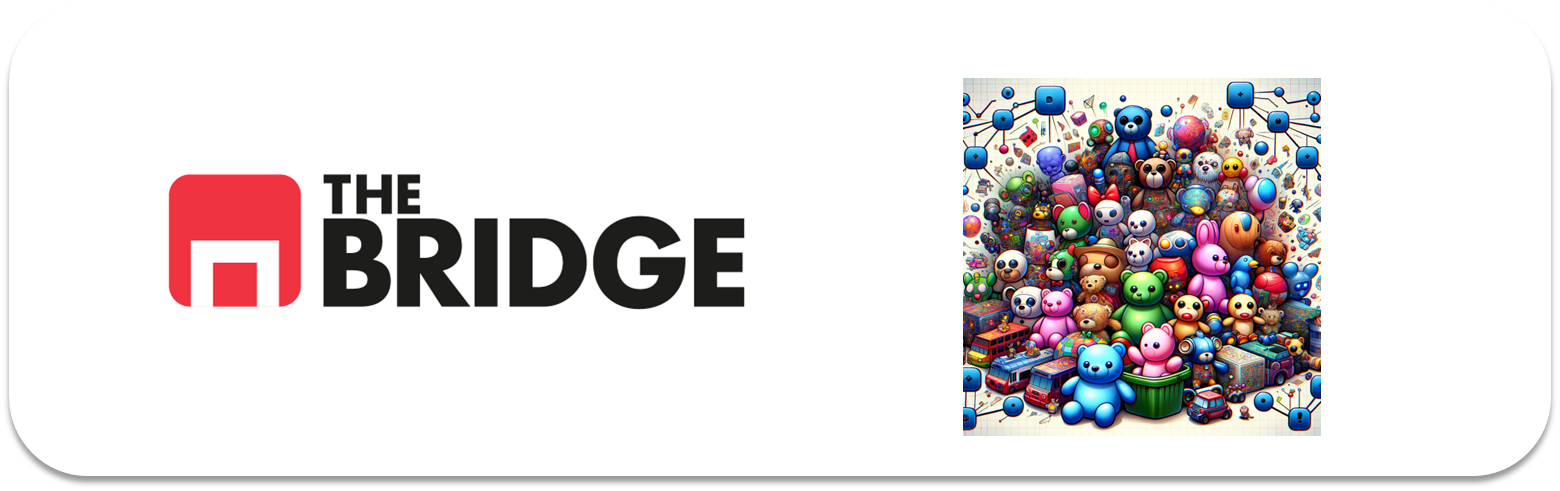

## PRACTICA OBLIGATORIA: **DBSCAN y Clustering Jerárquico**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [ ]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


pd.options.mode.copy_on_write = True

In [272]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)
    plt.figure(figsize=(9, 3.2))

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [273]:
df = pd.read_csv("./data/empowering_drinks.csv", sep="|")
df

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783
149,0.332758,-0.389355,-1.344582,0.280575,2.224236
150,0.209232,0.012732,-1.354622,0.296498,1.834923
151,1.395086,1.365208,-1.274305,-0.595160,1.791666


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [275]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

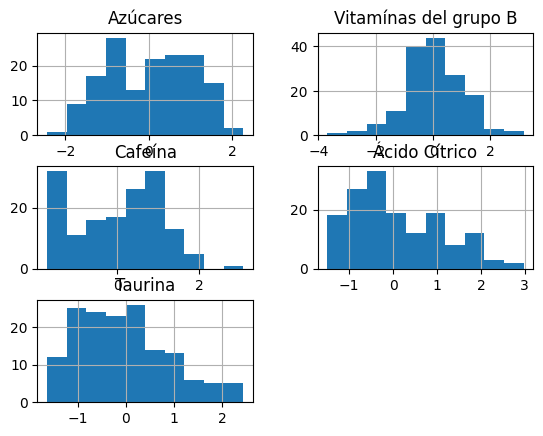

In [276]:
df.hist()

In [277]:
for col in df:
    print(df[col].value_counts())

Azúcares
-0.778980    5
-1.137207    5
 0.061000    4
-0.717217    3
-1.236028    3
            ..
-0.284874    1
 1.432144    1
 0.332758    1
 1.395086    1
 0.019564    1
Name: count, Length: 111, dtype: int64
Vitamínas del grupo B
-0.316249    7
-0.243142    6
 1.218995    5
-0.608676    5
 0.049285    5
            ..
 0.634140    1
 1.182441    1
 1.803849    1
 0.012732    1
 0.039106    1
Name: count, Length: 75, dtype: int64
Cafeína
 0.653312    3
-1.434939    3
-1.455019    3
 0.954502    2
 0.663351    2
            ..
-1.424900    1
-1.284344    1
-1.344582    1
-1.354622    1
-1.500000    1
Name: count, Length: 121, dtype: int64
Ácido Cítrico
-0.722540    5
-0.213021    4
-0.388168    4
 0.009893    4
-0.372246    3
            ..
-0.021952    1
 0.280575    1
 0.296498    1
-0.595160    1
 0.081020    1
Name: count, Length: 112, dtype: int64
Taurina
-0.544212    4
 0.234414    3
 0.018129    3
-0.241413    3
-0.198156    3
            ..
 1.142811    1
 2.224236    1
 1.8

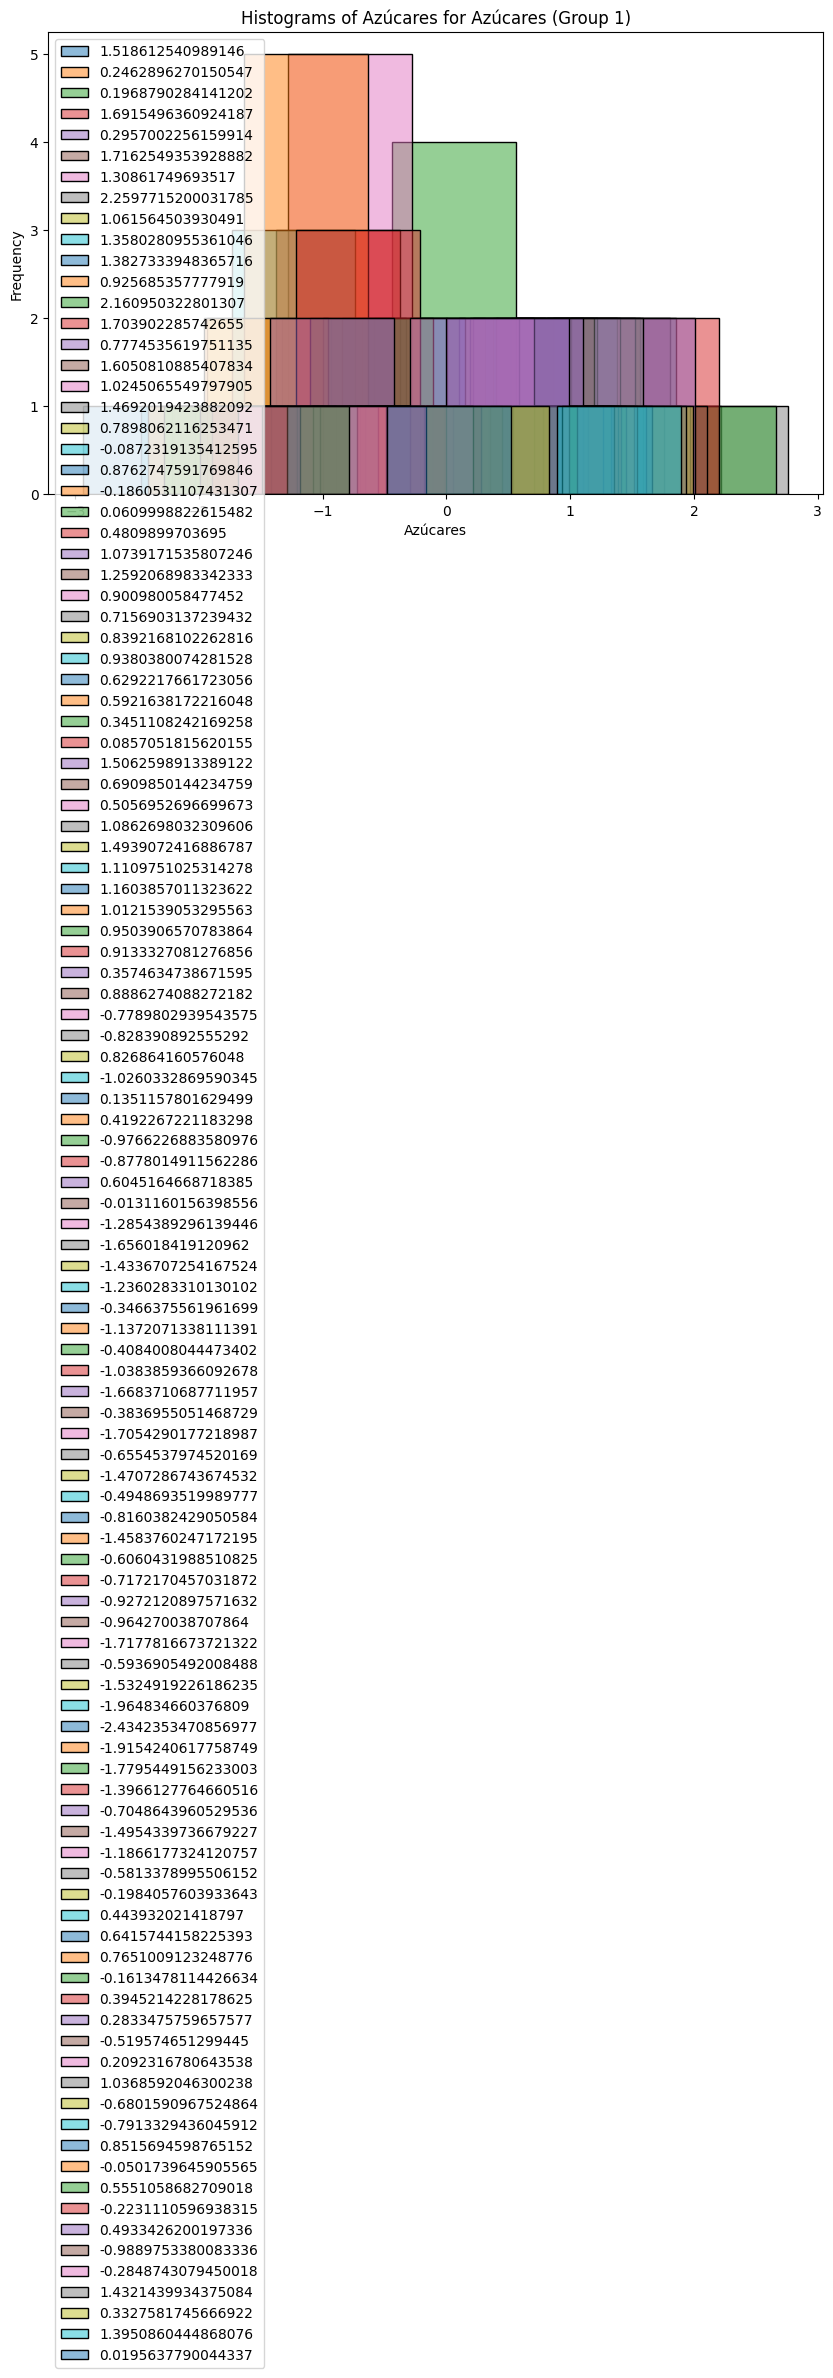

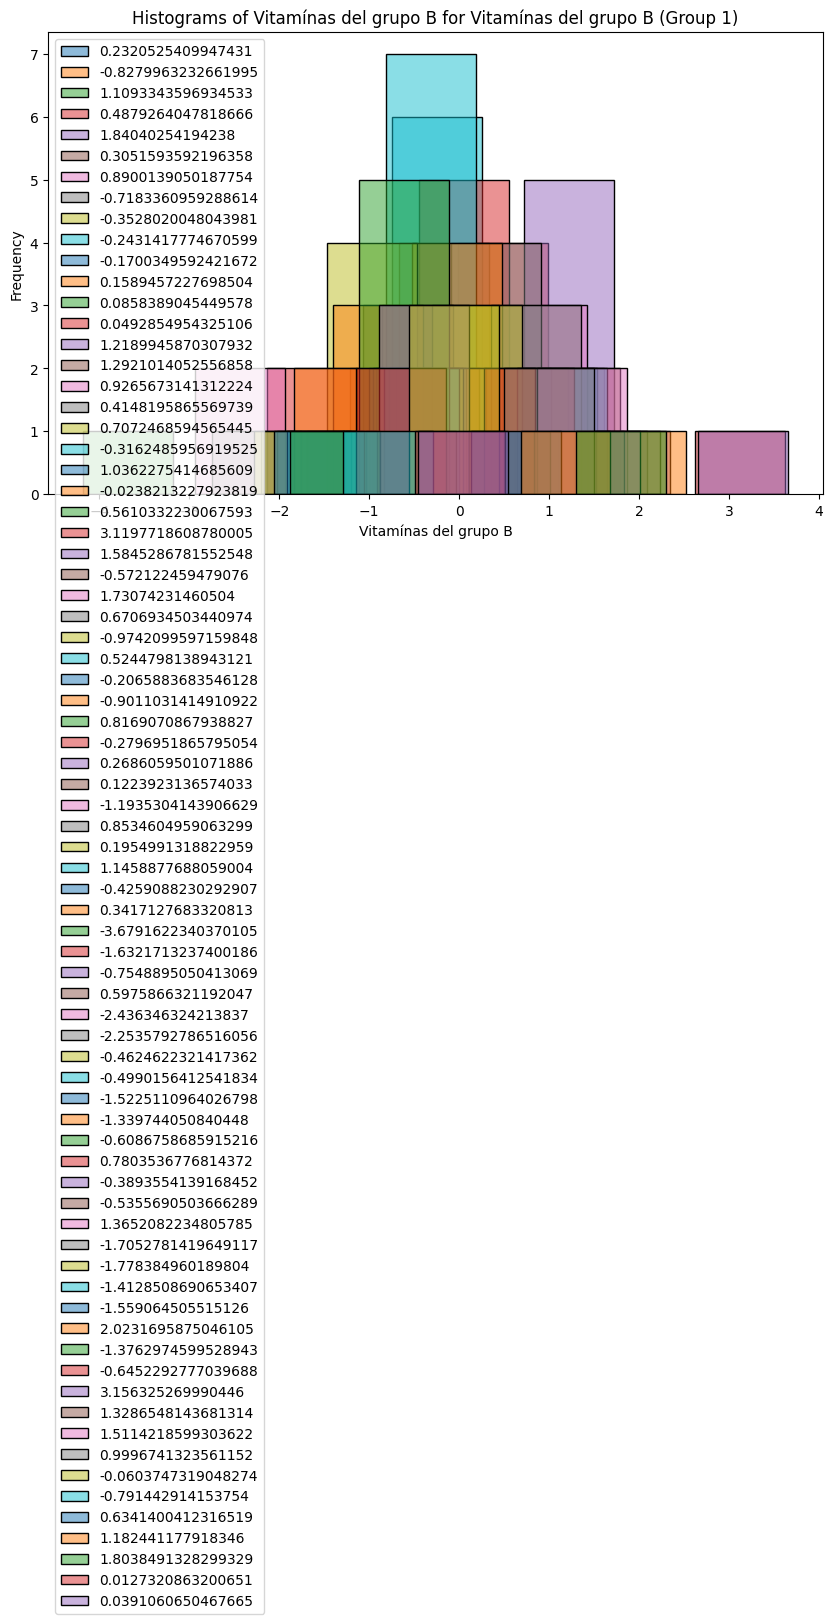

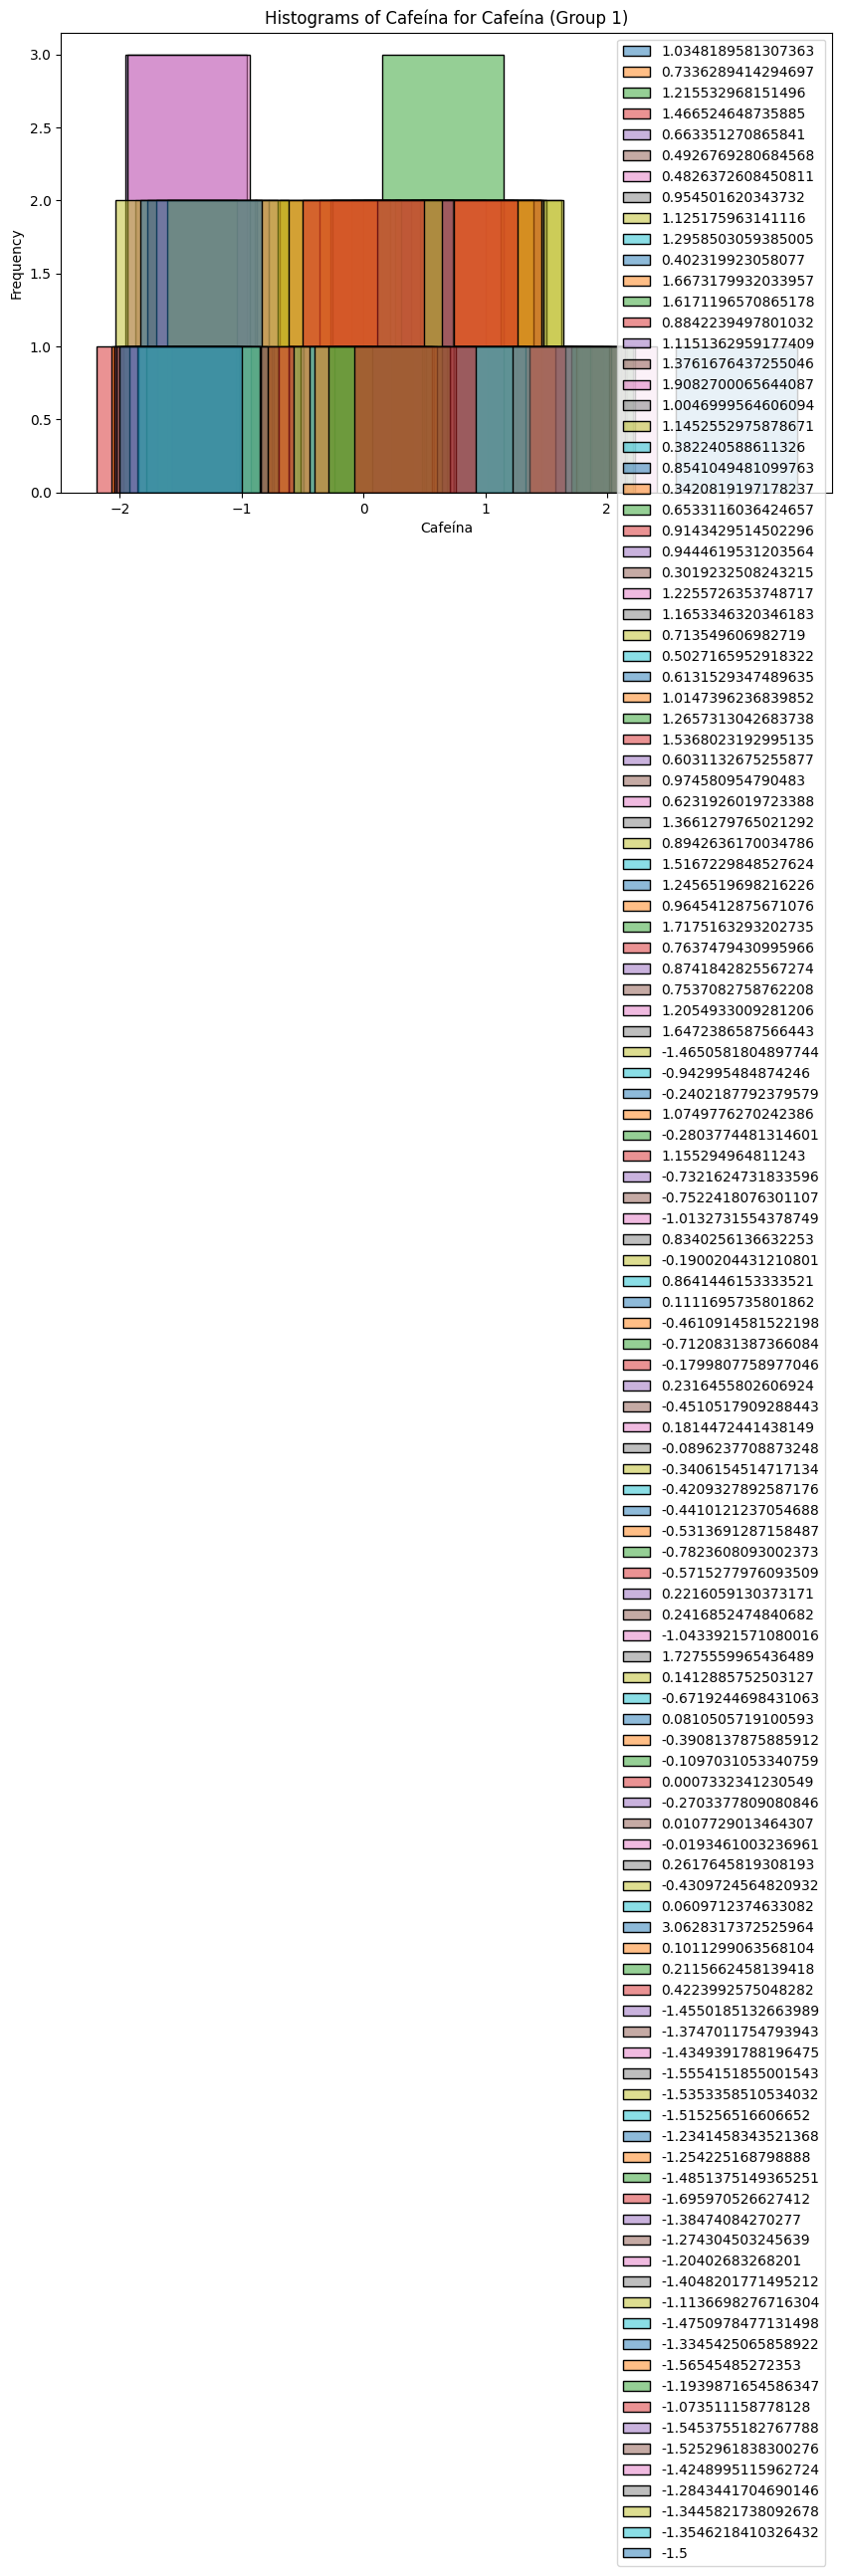

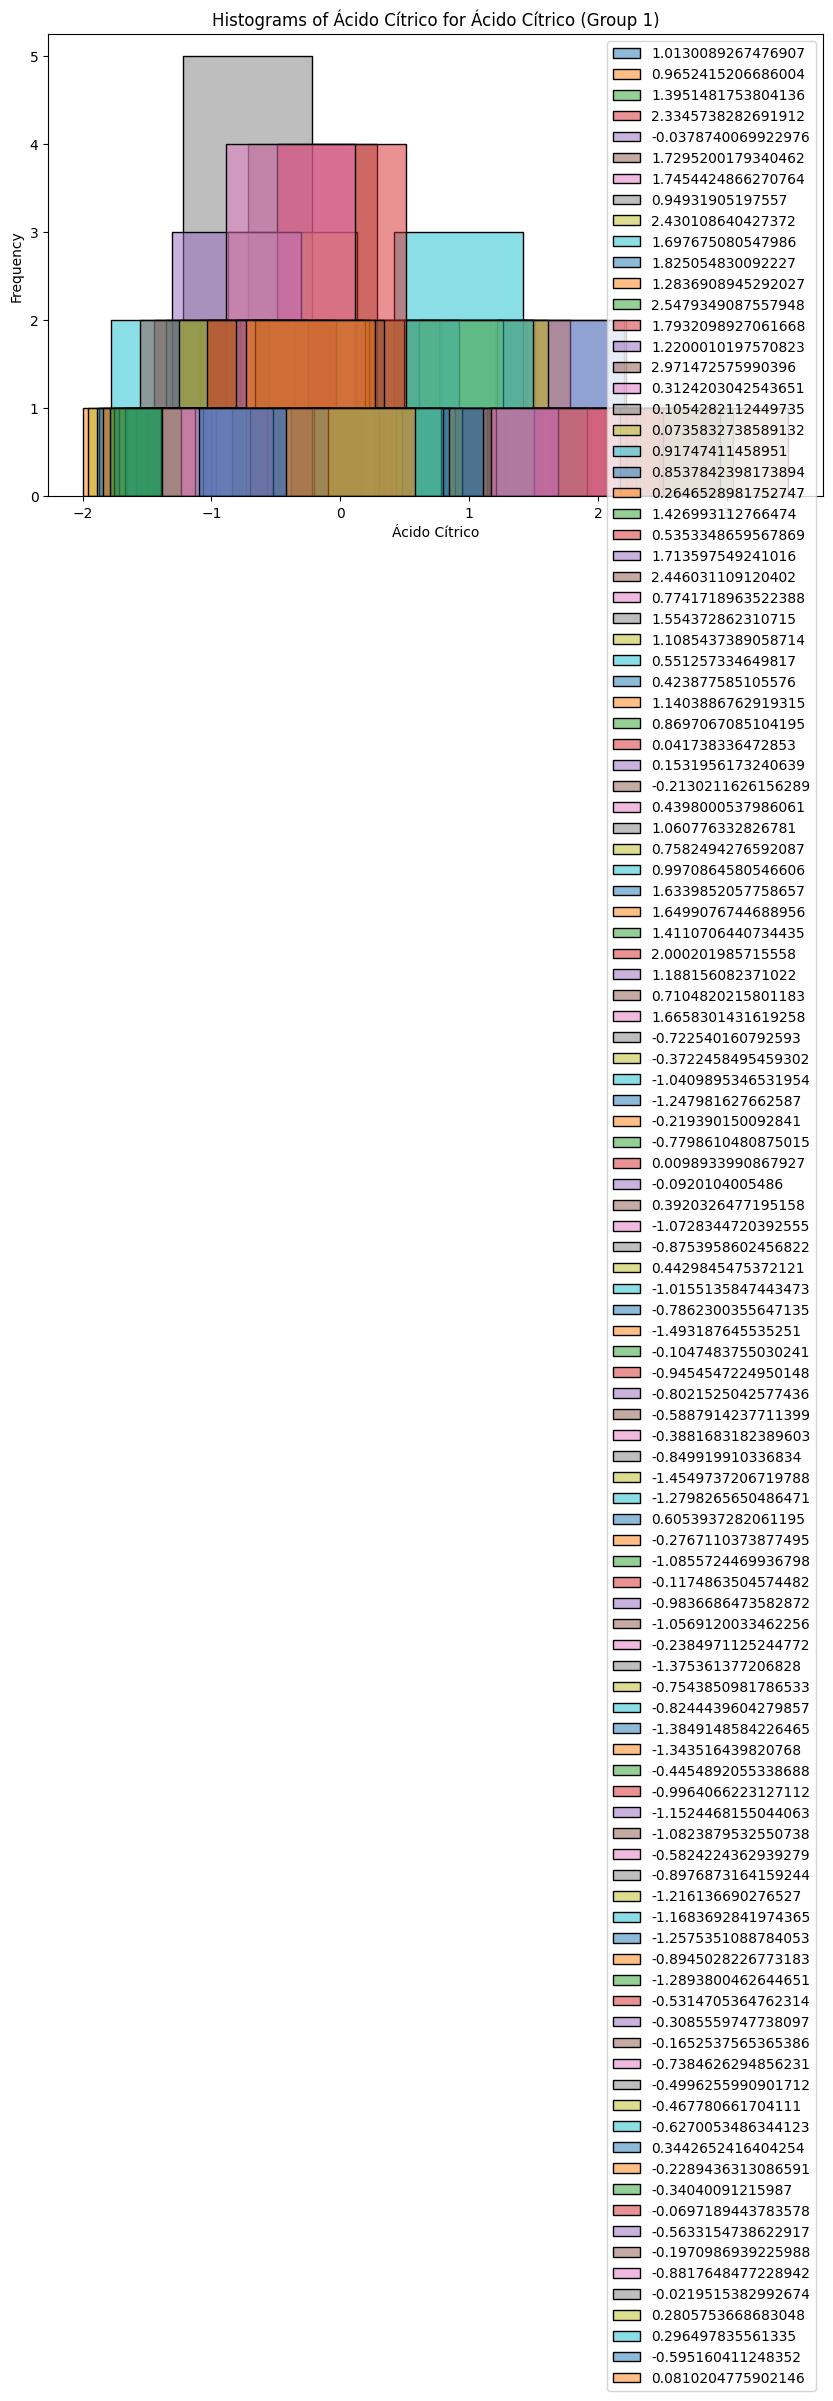

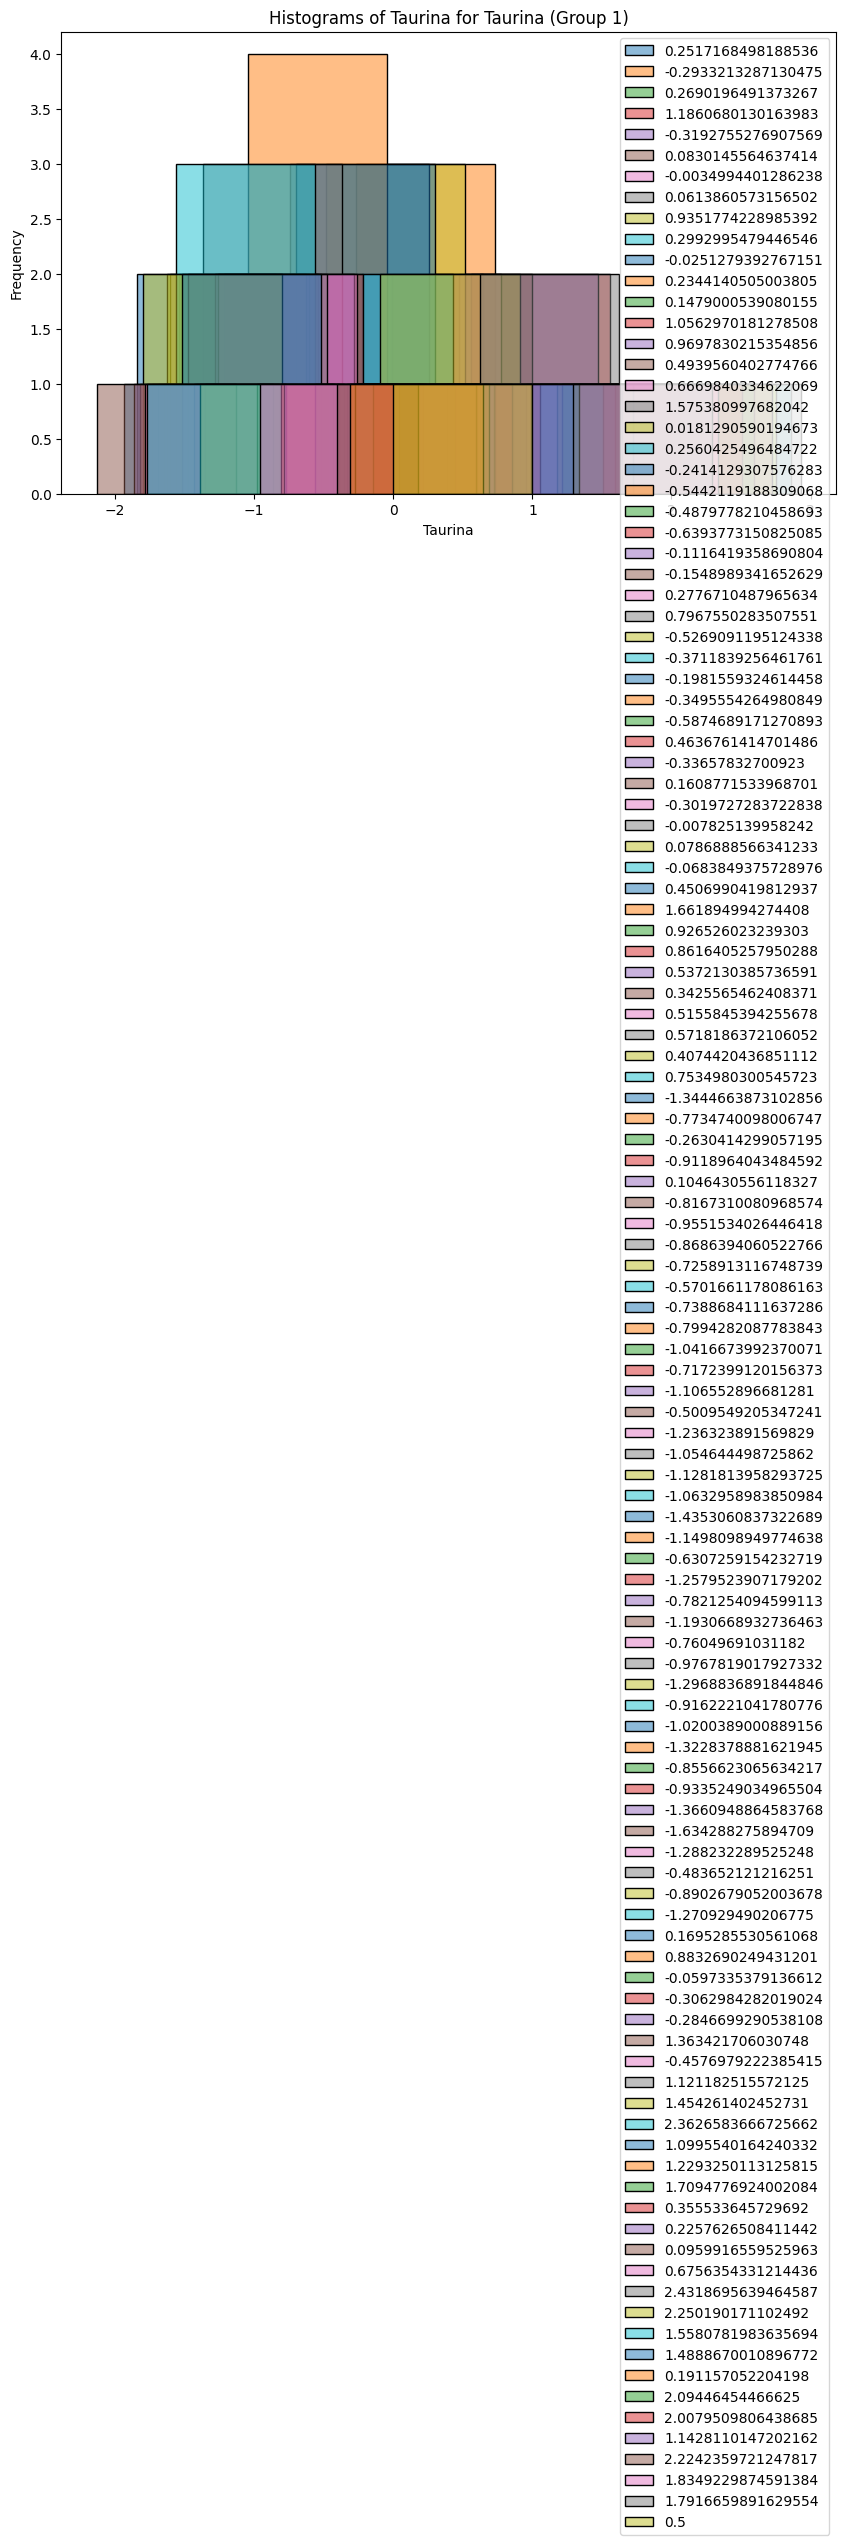

In [278]:
for col in df:
    bt.plot_grouped_histograms(df, cat_col= col, num_col= col, group_size= df[col].nunique())

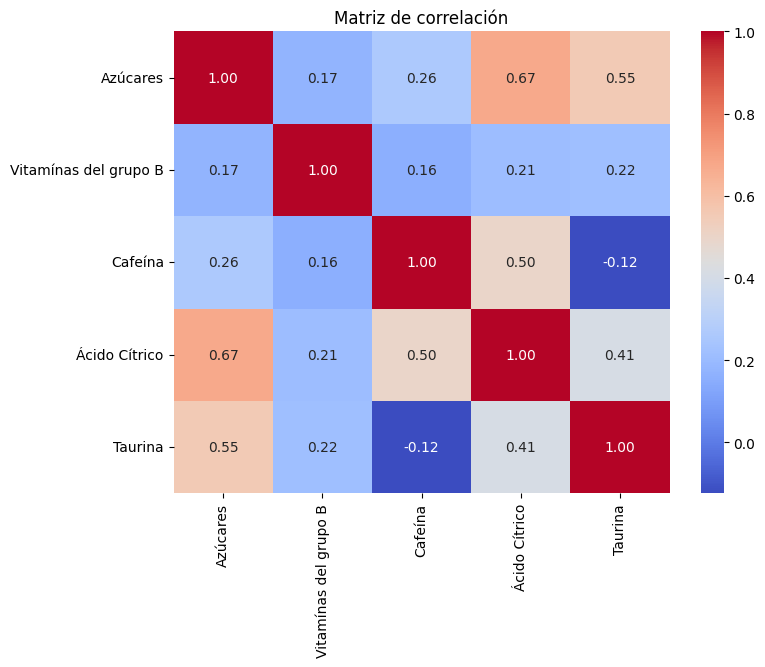

In [279]:

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


In [280]:
df.corr()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
Azúcares,1.000000,0.174354,0.258166,0.672969,0.553245
Vitamínas del grupo B,0.174354,1.000000,0.155276,0.208444,0.215869
Cafeína,0.258166,0.155276,1.000000,0.497329,-0.124157
Ácido Cítrico,0.672969,0.208444,0.497329,1.000000,0.408325
Taurina,0.553245,0.215869,-0.124157,0.408325,1.000000


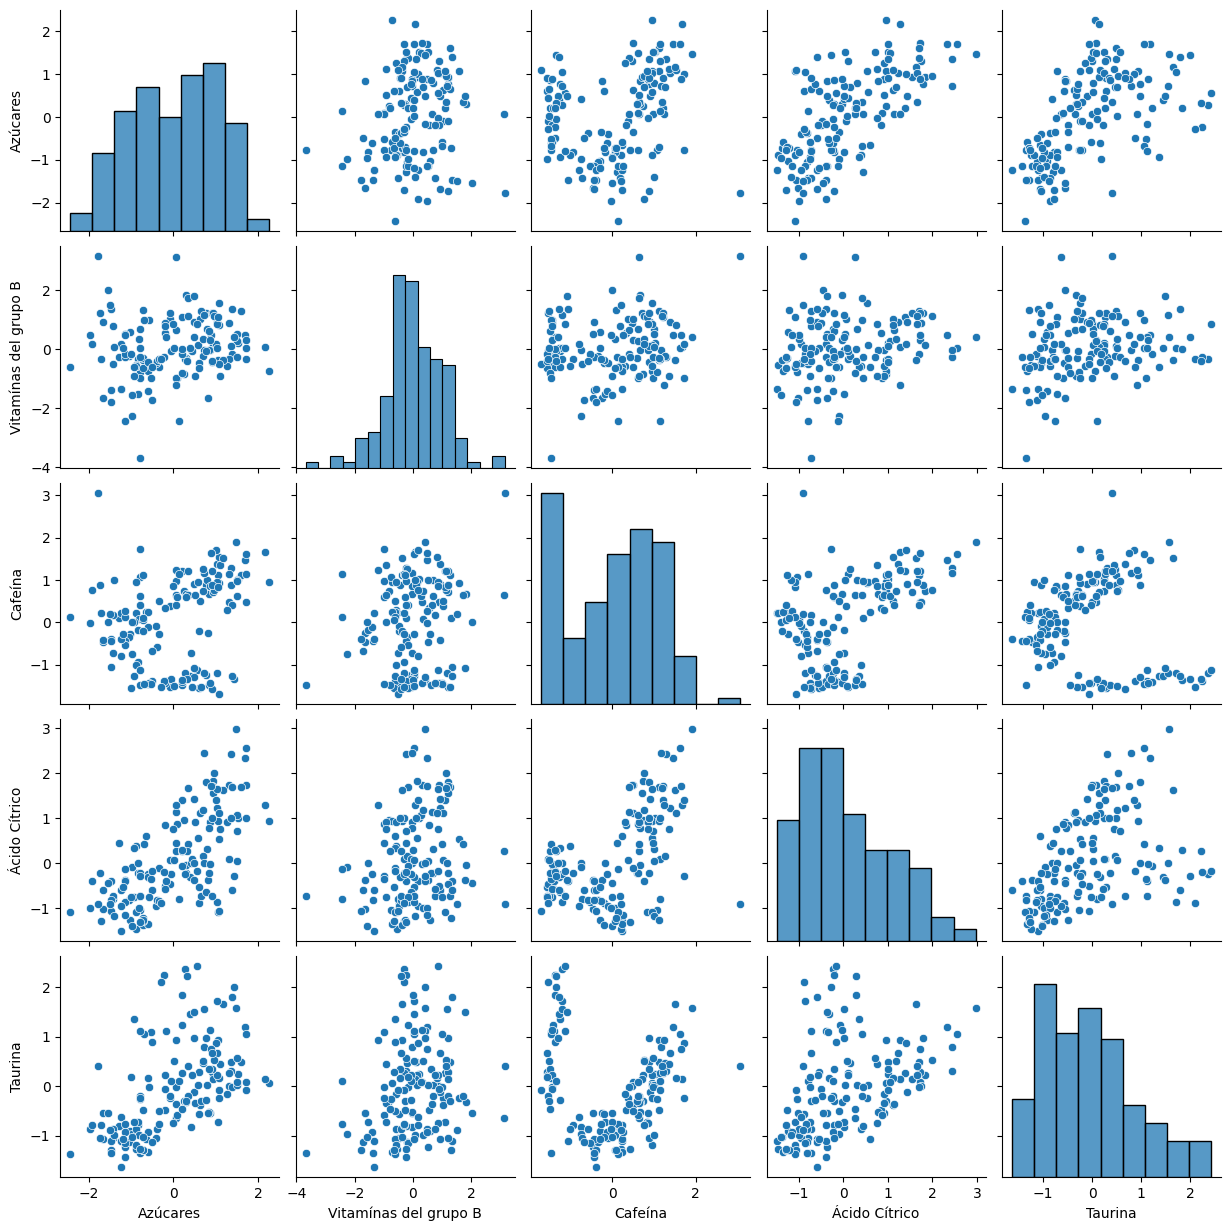

In [281]:
sns.pairplot(df)
plt.show()


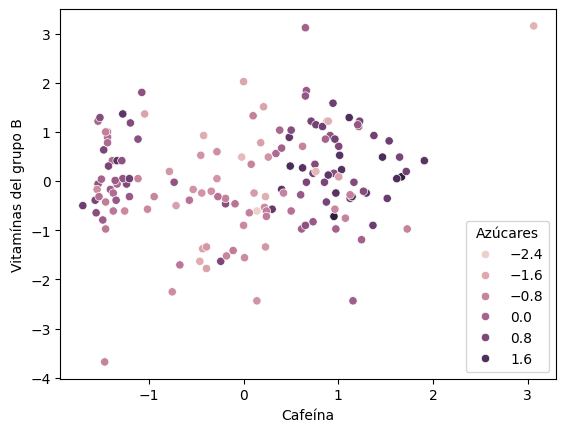

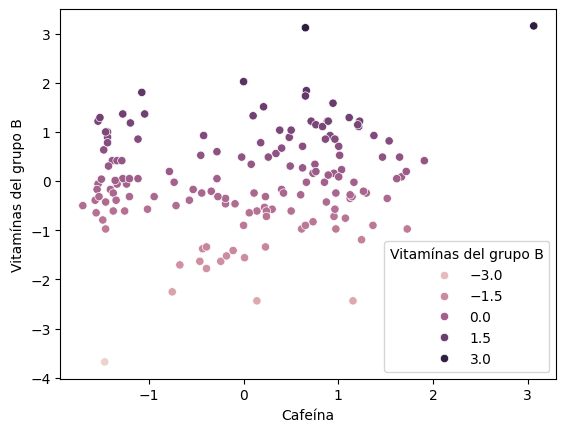

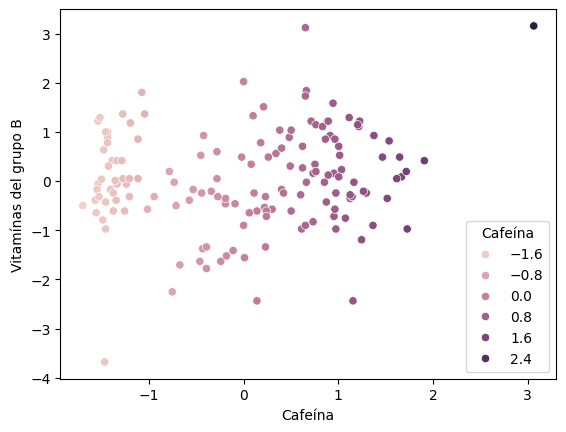

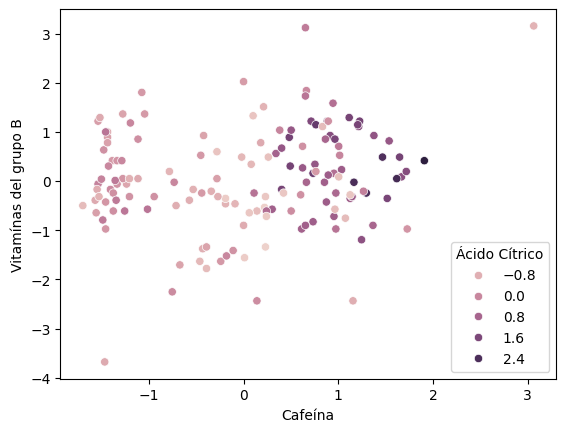

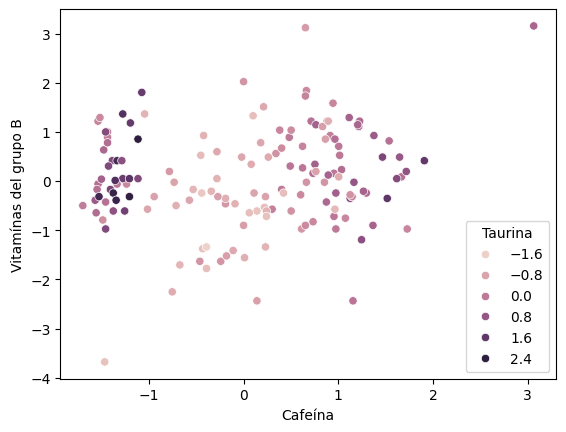

In [311]:
for hue in df.columns:
    sns.scatterplot(data=df, x=df.columns[2], y=df.columns[1], hue=hue)
    plt.show()

In [283]:
features = df.columns.to_list()

In [284]:
X = df[features]

In [285]:
#DBSCAN

In [286]:
dbscan = DBSCAN(eps=0.2,
                min_samples=5)
dbscan.fit(X)

,"eps eps: float, default=0.5The maximum distance between two samples for one to be consideredas in the neighborhood of the other. This is not a maximum boundon the distances of points within a cluster. This is the mostimportant DBSCAN parameter to choose appropriately for your data setand distance function. Smaller values generally lead to more clusters.",0.2
,"min_samples min_samples: int, default=5The number of samples (or total weight) in a neighborhood for a point tobe considered as a core point. This includes the point itself. If`min_samples` is set to a higher value, DBSCAN will find denser clusters,whereas if it is set to a lower value, the found clusters will be moresparse.",5
,"metric metric: str, or callable, default='euclidean'The metric to use when calculating distance between instances in afeature array. If metric is a string or callable, it must be one ofthe options allowed by :func:`sklearn.metrics.pairwise_distances` forits metric parameter.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors for DBSCAN... versionadded:: 0.17 metric *precomputed* to accept precomputed sparse matrix.",'euclidean'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function... versionadded:: 0.19",None
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'The algorithm to be used by the NearestNeighbors moduleto compute pointwise distances and find nearest neighbors.'auto' will attempt to decide the most appropriate algorithmbased on the values passed to :meth:`fit` method.See :class:`~sklearn.neighbors.NearestNeighbors` documentation fordetails.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or cKDTree. This can affect the speedof the construction and query, as well as the memory requiredto store the tree. The optimal value dependson the nature of the problem.",30
,"p p: float, default=NoneThe power of the Minkowski metric to be used to calculate distancebetween points. If None, then ``p=2`` (equivalent to the Euclideandistance). When p=1, this is equivalent to Manhattan distance.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [287]:
# El algoritmo
print(dbscan)

# Todos los datos etiquetados
print(len(dbscan.labels_))

# Los 10 primeros labels
print(dbscan.labels_[:10])

# Cuantos clusters ha montado
print(np.unique(dbscan.labels_))

DBSCAN(eps=0.2)
153
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1]


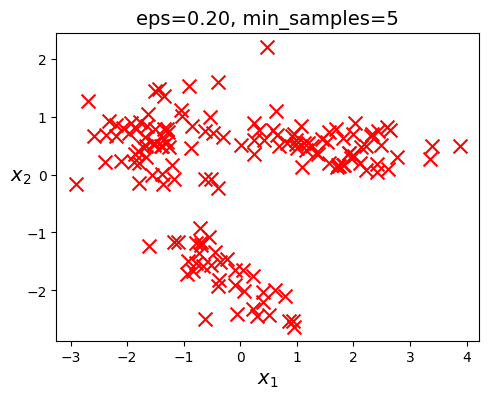

<Figure size 900x320 with 0 Axes>

In [288]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plot_dbscan(dbscan, X_pca, size=100)


plt.show()

In [289]:
print(len(dbscan.core_sample_indices_))

0


In [290]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.7)
X_pca = pca.fit_transform(X)

# Muy importante: DBSCAN debe ajustarse sobre X (5D), pero visualizarse sobre X_pca (2D)

In [291]:
db = DBSCAN(eps=0.40) #0.35 o  0.40
labels = db.fit_predict(X_pca)
np.unique(labels)


array([-1,  0,  1,  2])

In [292]:
# El algoritmo
print(db)

# Todos los datos etiquetados
print(len(db.labels_))

# Los 10 primeros labels
print(db.labels_[:10])

# Cuantos clusters ha montado
print(np.unique(db.labels_))

DBSCAN(eps=0.4)
153
[ 0  0  0 -1  0  0  0  0  0  0]
[-1  0  1  2]


In [293]:
print(len(db.core_sample_indices_))

117


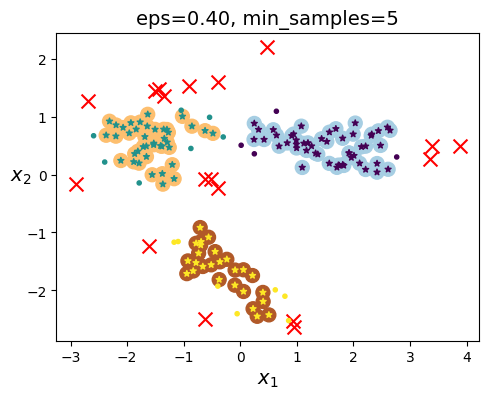

<Figure size 900x320 with 0 Axes>

In [294]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plot_dbscan(db, X_pca, size=100)


plt.show()

In [295]:
# #kneighbors
# neighbors = NearestNeighbors(n_neighbors=5)
# neighbors_fit = neighbors.fit(X)
# distances, indices = neighbors_fit.kneighbors(X)

# distances = np.sort(distances[:, 4])
# plt.figure(figsize=(8,4))
# plt.plot(distances)
# plt.title("k-distance plot (k=5)")
# plt.xlabel("Puntos ordenados")
# plt.ylabel("Distancia al 5º vecino")
# plt.show()

In [296]:
# for eps in [0.3, 0.35, 0.4, 0.45, 110]:
#     db = DBSCAN(eps=eps, min_samples=5)
#     labels = db.fit_predict(X)
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     print(f"eps={eps}, clusters={n_clusters}, unique={np.unique(labels)}")

In [297]:
#BOTTOM UP o aglomerativa

In [298]:
agg = AgglomerativeClustering(n_clusters=5, linkage="ward") #5 o 4
labels_agg = agg.fit_predict(X)

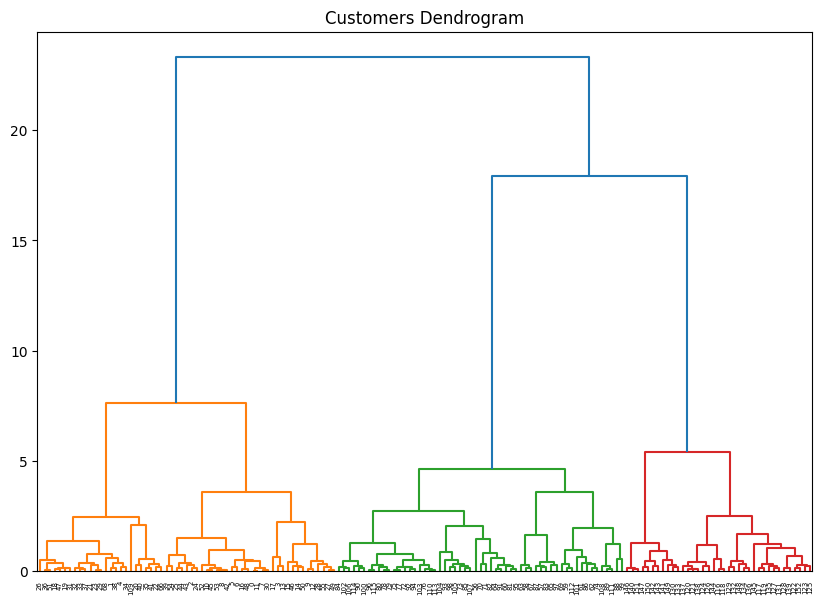

In [299]:

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

selected_data = X_pca
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

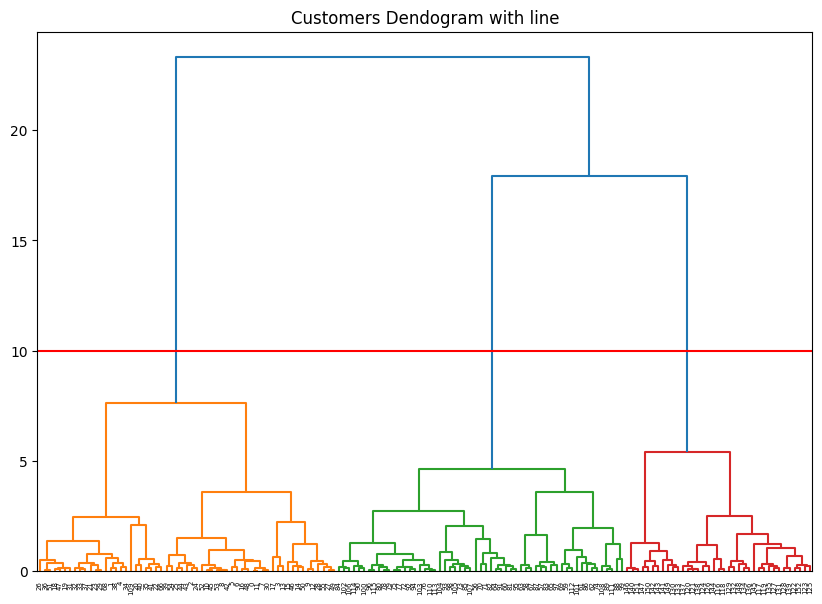

In [300]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(X_pca, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 10, color = 'r', linestyle = '-')

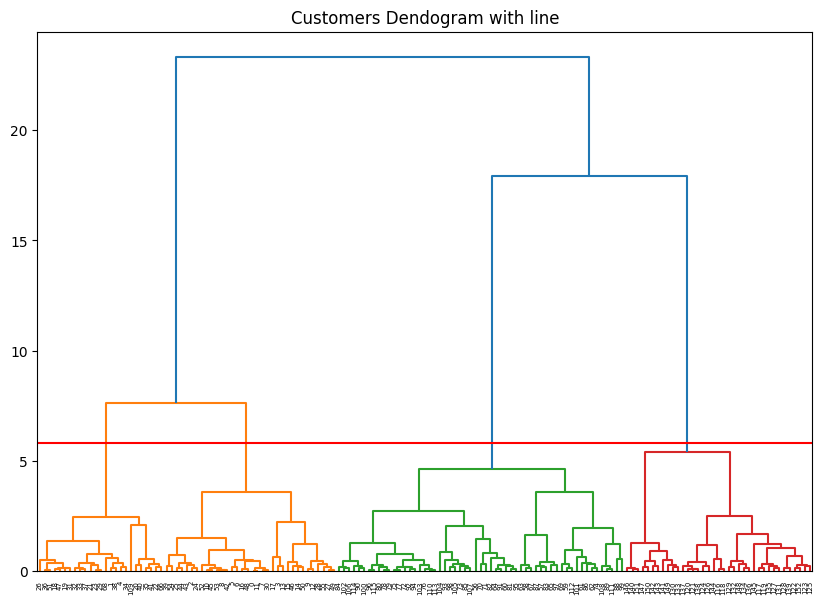

In [301]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(X_pca, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 5.8, color = 'r', linestyle = '-')

In [302]:
clustering_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [303]:
agg4 = AgglomerativeClustering(n_clusters=4, linkage="ward")
labels_agg4 = agg4.fit_predict(X)

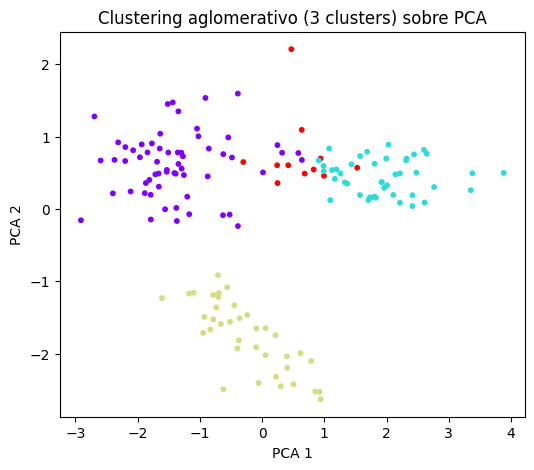

In [304]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg4, cmap="rainbow", s=10)
plt.title("Clustering aglomerativo (3 clusters) sobre PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [305]:

agg3 = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_agg3 = agg3.fit_predict(X)


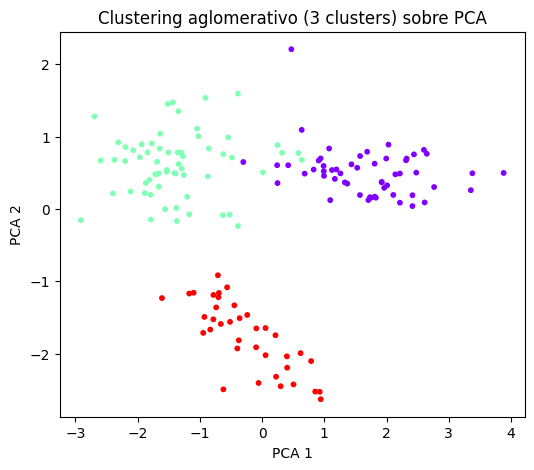

In [306]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg3, cmap="rainbow", s=10)
plt.title("Clustering aglomerativo (3 clusters) sobre PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [307]:
new = pd.read_csv("./data/new_experiments.csv",sep="|")
new

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [308]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(X)
#Una vez se ha encontrado el K, la prediccion es sobre los datos originales? y el fit? o con x_pca

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [309]:
new_clusters = kmeans3.predict(new)
new_clusters

array([2, 2, 0, 0, 1, 1], dtype=int32)

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.